In [64]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import scanpy
import os
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pyroe
import itertools
import scipy.stats as stats
from matplotlib.colors import LogNorm, Normalize

In [65]:
def read_classification_table(context, path_dict):
    m = pd.read_table(path_dict[context]['m'], names=['bc', 'status'])
    m['sim_status'] = 'mature'
    n = pd.read_table(path_dict[context]['n'], names=['bc', 'status'])
    n['sim_status'] = 'nascent'
    return pd.concat([m,n])

In [66]:
sns.set_style('white')
sns.set_context('talk')

In [67]:
mn = {
    'afi' : 'alevin-fry(splici)',
    'afu' : 'alevin-fry(spliceu)',
    'afup' : 'alevin-fry(spliceu, piscem)',
    'kbd' : 'kallisto(D-list)|bustools'
}

In [68]:
basedir = json.load(open('notebook_paths.json'))['classification_root_path']

In [69]:
map_base = {
    mn['afup'] : os.path.sep.join([basedir, 'alevin_fry_spliceu_piscem_results/piscem_map']),
    mn['afu'] : os.path.sep.join([basedir, 'alevin_fry_spliceu_results/af_spliceu_map']),
    mn['afi'] : os.path.sep.join([basedir, 'alevin_fry_splici_results/af_splici_map']),
    mn['kbd'] : os.path.sep.join([basedir, 'kallisto_bustools_results/kbd_map'])
}

In [70]:
truth_basedir = os.path.sep.join([basedir, 'data/bbmap_sim/matching_based_truth'])

In [71]:
truth_files = {
    'cyto' : {
        'm' : os.path.sep.join([truth_basedir, 'cytoplasmic_mature_splice_status_truth.tsv']),
        'n' : os.path.sep.join([truth_basedir, 'cytoplasmic_nascent_splice_status_truth.tsv'])
    },
    'nuc' : {
        'm' : os.path.sep.join([truth_basedir, 'nuclear_mature_splice_status_truth.tsv']),
        'n' : os.path.sep.join([truth_basedir, 'nuclear_nascent_splice_status_truth.tsv'])
    }
}

In [72]:
truth = {}

In [73]:
truth['cyto'] = read_classification_table('cyto', truth_files)

In [74]:
truth['nuc'] = read_classification_table('nuc', truth_files)

In [75]:
map_dirs = {
    k : {
        'cyto' : {
            'm' : '/'.join([v, 'cytoplasmic_mature_splice_status_empirical.tsv']),
            'n' : '/'.join([v, 'cytoplasmic_nascent_splice_status_empirical.tsv'])
        },
        'nuc' : {
            'm' : '/'.join([v, 'nuclear_mature_splice_status_empirical.tsv']),
            'n' : '/'.join([v, 'nuclear_nascent_splice_status_empirical.tsv'])
        }  
    }
    for k,v in map_base.items()
}

In [76]:
map_res = {}
for k,v in map_dirs.items():
    print(f"loading results for {k}")
    map_res[k] = {
        'cyto' : read_classification_table('cyto', v),
        'nuc' : read_classification_table('nuc', v)
    }

loading results for alevin-fry(spliceu, piscem)
loading results for alevin-fry(spliceu)
loading results for alevin-fry(splici)
loading results for kallisto(D-list)|bustools


In [77]:
def get_joint_df(context, truth, pred):
    merged_df = truth[context].merge(pred[context], left_on='bc', right_on='bc', suffixes=['', '_pred'], how='outer')
    merged_df["status"] = ["A" if s == "a" else "M" if s == "m" else "N" if s == "n" else "unmapped" for s in merged_df["status"]]
    merged_df["status_pred"] = ["A" if s == "a" else "M" if s == "m" else "N" if s == "n" else "unmapped" for s in merged_df["status_pred"]]
    return merged_df

In [78]:
def plot_heatmap(joint_df, context, method, true_key, pred_key):
    pivot_df = (joint_df.fillna('U').groupby([true_key, pred_key], \
                          sort=False).size().\
            reset_index(name='count').\
            pivot(true_key, pred_key, 'count').fillna(0) + 1) / joint_df.shape[0]

    pivot_df.index = pd.CategoricalIndex(pivot_df.index, categories= ['M', 'N', 'A'], ordered=True)
    pivot_df.columns = pd.CategoricalIndex(pivot_df.columns, categories= ['M', 'N', 'A', 'unmapped'], ordered=True)
    pivot_df.sort_index(level='status', inplace=True)
    pivot_df.sort_index(axis=1, inplace=True)
    pivot_df.reindex(index=['M', 'N', 'A'], columns=['M', 'N', 'A', 'unmapped'])
    h = sns.heatmap(pivot_df, annot=True, \
            cmap=sns.color_palette("Blues", as_cmap=True),\
            norm=LogNorm(0.01, 1.0),
            fmt=".2%",
            linewidth=1, linecolor='w', square=True,
            cbar=False)
    h.set_yticklabels(h.get_yticklabels(), rotation = 0)
    title = f'Method : {method}\nContext : {context}'
    return h, title

In [79]:
j_nuc = get_joint_df('nuc', truth, map_res[k])

In [80]:
pivot_df = (j_nuc.fillna('U').groupby(['status', 'status_pred'], \
                          sort=False).size().\
            reset_index(name='count').\
            pivot('status', 'status_pred', 'count').fillna(0) + 1) / j_nuc.shape[0]
    

In [81]:
    pivot_df.index = pd.CategoricalIndex(pivot_df.index, categories= ['M', 'N', 'A'], ordered=True)
    pivot_df.columns = pd.CategoricalIndex(pivot_df.columns, categories= ['M', 'N', 'A', 'unmapped'], ordered=True)
    pivot_df.sort_index(level='status', inplace=True)
    pivot_df.sort_index(axis=1, inplace=True)

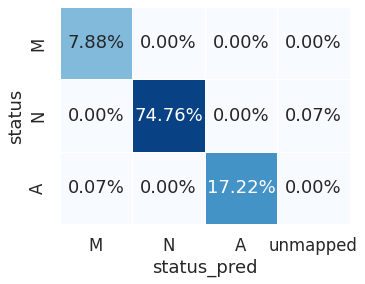

In [82]:
 h = sns.heatmap(pivot_df, annot=True, \
            cmap=sns.color_palette("Blues", as_cmap=True),\
            norm=LogNorm(0.01, 1.0),
            fmt=".2%",
            linewidth=1, linecolor='w', square=True,
            cbar=False)

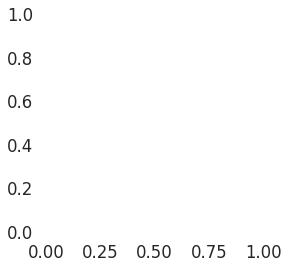

In [83]:
for m in mn:
    k = mn[m]
    v = map_res[k]
    j_nuc = get_joint_df('nuc', truth, map_res[k])
    j_cyto = get_joint_df('cyto', truth, map_res[k])

    (h, title) = plot_heatmap(j_nuc, 'nuclear', k, 'status', 'status_pred')
    plt.title(title)
    plt.xlabel("Predicted Status")
    plt.ylabel("Matching-based Truth")
    plt.savefig(f'plots/confusion_mtx_nuclear_{m}.pdf', bbox_inches='tight')
    plt.cla()

    (h, title) = plot_heatmap(j_cyto, 'cytoplasm', k, 'status', 'status_pred')
    plt.title(title)
    plt.xlabel("Predicted Status")
    plt.ylabel("Matching-based Truth")
    plt.savefig(f'plots/confusion_mtx_cyto_{m}.pdf', bbox_inches='tight')
    plt.cla()

In [84]:
def plot_truth_heatmap(joint_df, context, method, true_key, pred_key):
    pivot_df = (joint_df.fillna('unmapped').groupby([true_key, pred_key], \
                          sort=False).size().\
            reset_index(name='count').\
            pivot(true_key, pred_key, 'count').fillna(0) + 1) / joint_df.shape[0]
    pivot_df = pivot_df.rename(index={'a' : 'A', 'm' : 'M', 'n' : 'N'})
    pivot_df.index = pd.CategoricalIndex(pivot_df.index, categories= ['M', 'N', 'A'], ordered=True)
    print(pivot_df)
    pivot_df.sort_index(level='status', inplace=True)

    h = sns.heatmap(pivot_df, annot=True, \
            
            cmap=sns.color_palette("Blues", as_cmap=True),\
            norm=LogNorm(0.01, 1.0),
            fmt=".2%",
            linewidth=1, linecolor='w', square=True,
            cbar=False)
    h.set_yticklabels(h.get_yticklabels(), rotation = 0)
    
    title = f'Context : {context}'
    return h, title

In [85]:
pivot_df = (truth['nuc'].fillna('unmapped').groupby(['status', 'sim_status'], \
                          sort=False).size().\
            reset_index(name='count').\
            pivot('status', 'sim_status', 'count').fillna(0) + 1) / truth['nuc'].shape[0]

In [86]:
pivot_df = pivot_df.rename(index={'a' : 'A', 'm' : 'M', 'n' : 'N'})
pivot_df.index = pd.CategoricalIndex(pivot_df.index, categories= ['M', 'N', 'A'], ordered=True)

In [87]:
pivot_df.index

CategoricalIndex(['A', 'M', 'N'], categories=['M', 'N', 'A'], ordered=True, dtype='category', name='status')

sim_status        mature       nascent
status                                
A           1.211932e-01  5.167400e-02
M           7.880720e-02  2.000000e-07
N           2.000000e-07  7.483264e-01


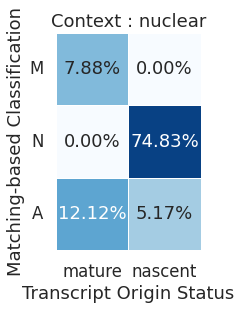

In [90]:
(h, title) = plot_truth_heatmap(truth['nuc'], 'nuclear', 'truth', 'status', 'sim_status')
plt.title(title)
plt.xlabel("Transcript Origin Status")
plt.ylabel("Matching-based Classification")
plt.savefig('plots/true_vs_empirical_nuc_v2.pdf', bbox_inches='tight')

sim_status        mature       nascent
status                                
A           4.845906e-01  1.294880e-02
M           3.154098e-01  2.000000e-07
N           2.000000e-07  1.870516e-01


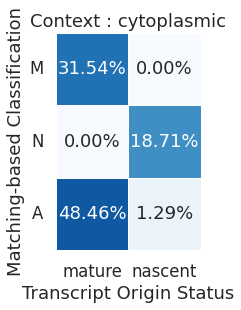

In [91]:
(h, title) = plot_truth_heatmap(truth['cyto'], 'cytoplasmic', 'truth', 'status', 'sim_status')
plt.title(title)
plt.xlabel("Transcript Origin Status")
plt.ylabel("Matching-based Classification")
plt.savefig('plots/true_vs_empirical_cyto_v2.pdf', bbox_inches='tight')